In [1]:
import os
import torch
import yaml
import matplotlib.pyplot as plt
from PIL import Image

from inference import load_model, prepare_image, get_prediction, visualize_predictions

In [10]:
# Set paths
MODEL_PATH = "./artifacts/best_model.pth"  # Path to your trained model
TEST_IMAGE_DIR = "assignment_data_bdd/bdd100k_images_100k/bdd100k/images/100k/test"  # Directory with test images
OUTPUT_DIR = "notebook_outputs"  # Directory to save outputs

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Load the trained model
model = load_model(MODEL_PATH, config['num_classes'])
model.to(device)
print(f"Model loaded from {MODEL_PATH}")

Model loaded from ./artifacts/best_model.pth


In [12]:
from src.constants import class_to_idx

# Create inverse mapping from indices to class names
class_to_idxs = {v: k for k, v in class_to_idx.items()}
class_to_idxs[0] = "background"  # Add background class

print("Class mapping:")
for idx, name in sorted(class_to_idxs.items()):
    print(f"{idx}: {name}")

Class mapping:
0: background
1: pedestrian
2: rider
3: car
4: truck
5: bus
6: train
7: motorcycle
8: bicycle
9: traffic light
10: traffic sign


In [13]:
# List images in the directory
image_extensions = [".jpg", ".jpeg", ".png"]
image_files = [f for f in os.listdir(TEST_IMAGE_DIR) 
              if os.path.splitext(f)[1].lower() in image_extensions]

print(f"Found {len(image_files)} images in {TEST_IMAGE_DIR}")

Found 20000 images in assignment_data_bdd/bdd100k_images_100k/bdd100k/images/100k/test


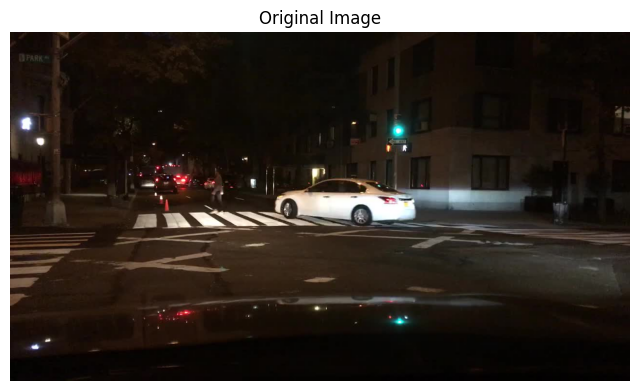

Detected 0 objects


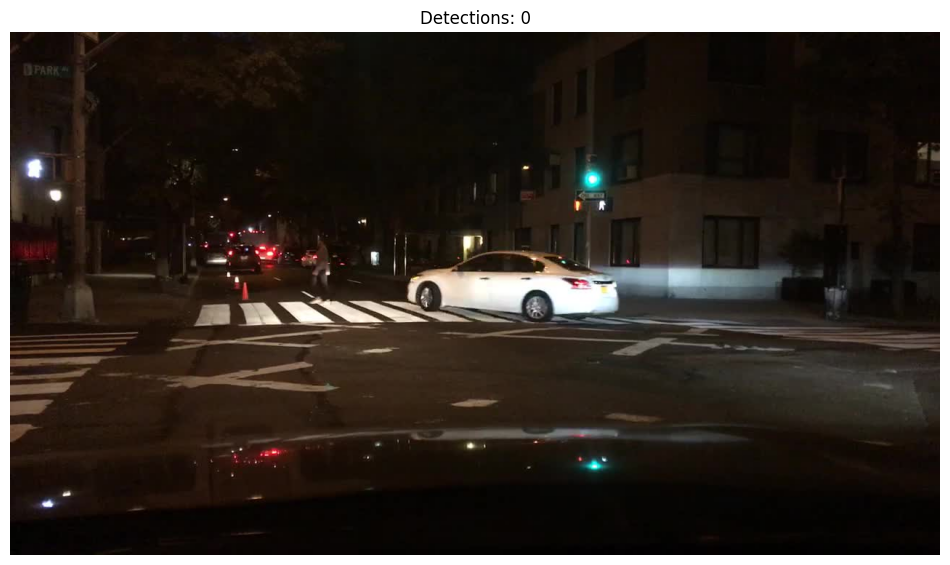

In [17]:
idx_to_class = {v: k for k, v in class_to_idx.items()}
idx_to_class[0] = "background"  # Add background class
# Process one image as an example
if image_files:
    # Select the first image
    image_path = os.path.join(TEST_IMAGE_DIR, image_files[0])
    
    # Display original image
    plt.figure(figsize=(8, 6))
    plt.imshow(Image.open(image_path))
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
    
    # Prepare image for model
    image_tensor = prepare_image(image_path, config['img_dim'])
    
    # Run inference
    prediction = get_prediction(model, image_tensor, device, threshold=0.5)
    
    # Display predictions
    print(f"Detected {len(prediction['boxes'])} objects")
    for i, (box, label, score) in enumerate(zip(prediction['boxes'], prediction['labels'], prediction['scores'])):
        class_name = idx_to_class[label.item()]
        print(f"Detection {i+1}: {class_name} (Score: {score:.3f}) at {box.tolist()}")
    
    # Visualize predictions
    visualize_predictions(image_path, prediction)
else:
    print("No images found in directory!")

In [18]:
# Process all images in the directory
def process_images(image_files, threshold=0.5):
    for img_file in image_files:
        img_path = os.path.join(TEST_IMAGE_DIR, img_file)
        print(f"\nProcessing {img_path}...")
        
        # Prepare image
        image_tensor = prepare_image(img_path, config['img_dim'])
        
        # Get prediction
        prediction = get_prediction(model, image_tensor, device, threshold)
        
        # Print results
        print(f"Detected {len(prediction['boxes'])} objects")
        class_counts = {}
        for label in prediction['labels']:
            class_name = class_to_idxs[label.item()]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
        
        for class_name, count in class_counts.items():
            print(f"  - {class_name}: {count}")
        
        # Save visualization
        output_path = os.path.join(OUTPUT_DIR, f"{os.path.splitext(img_file)[0]}_detection.jpg")
        visualize_predictions(img_path, prediction, output_path)
        
# Process first 3 images only (to avoid making the notebook too large)
if len(image_files) > 0:
    process_images(image_files[:min(3, len(image_files))])
    print(f"\nResults saved to {OUTPUT_DIR}")
else:
    print("No images found in directory!")


Processing assignment_data_bdd/bdd100k_images_100k/bdd100k/images/100k/test/d0a15438-330af88e.jpg...
Detected 0 objects
Saved visualization to notebook_outputs/d0a15438-330af88e_detection.jpg

Processing assignment_data_bdd/bdd100k_images_100k/bdd100k/images/100k/test/cf62dd45-c71fefbe.jpg...
Detected 0 objects
Saved visualization to notebook_outputs/cf62dd45-c71fefbe_detection.jpg

Processing assignment_data_bdd/bdd100k_images_100k/bdd100k/images/100k/test/d8960a48-83c08a3d.jpg...
Detected 0 objects
Saved visualization to notebook_outputs/d8960a48-83c08a3d_detection.jpg

Results saved to notebook_outputs


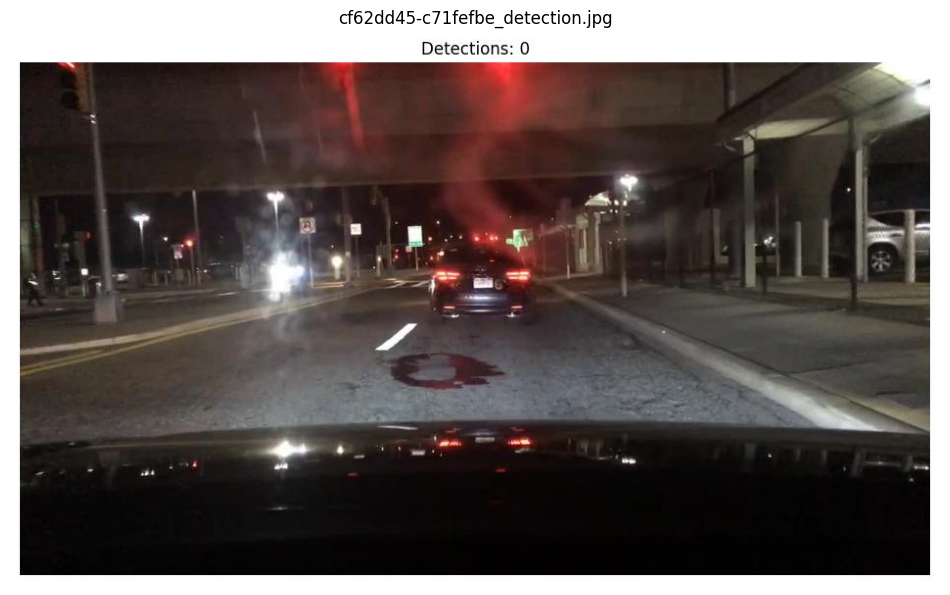

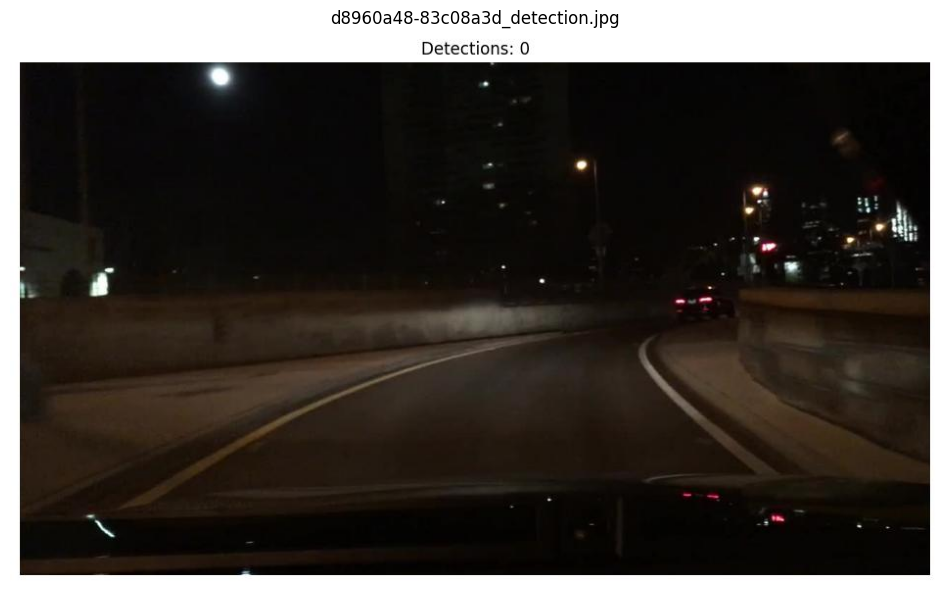

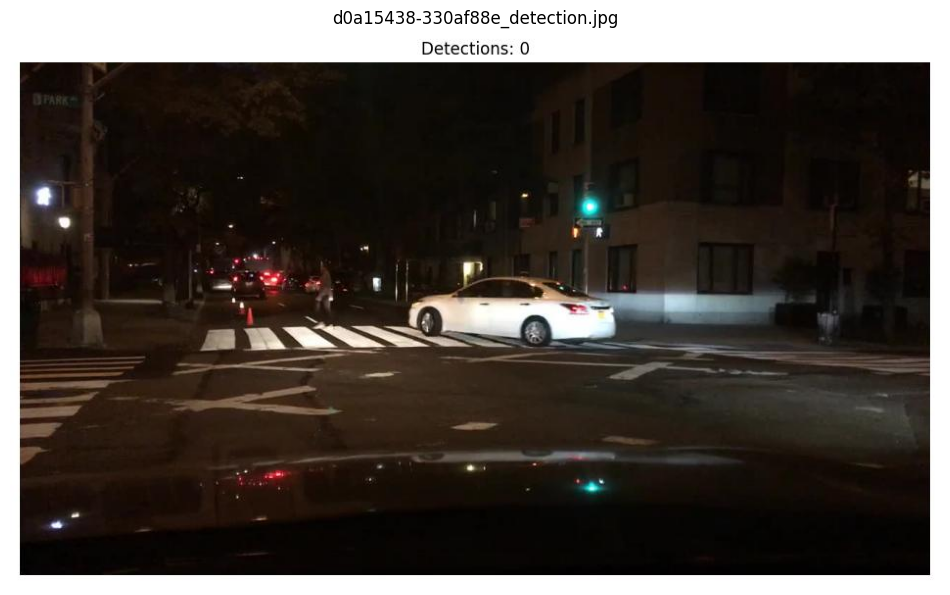

In [19]:
# Display the saved detection images
output_files = [f for f in os.listdir(OUTPUT_DIR) 
               if f.endswith('_detection.jpg')]

for i, output_file in enumerate(output_files[:3]):  # Show first 3 outputs
    plt.figure(figsize=(12, 8))
    img = Image.open(os.path.join(OUTPUT_DIR, output_file))
    plt.imshow(img)
    plt.title(output_file)
    plt.axis('off')
    plt.show()